## Time Series Forecasting with American Electric Power Consumption

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv("AEP_hourly.csv")
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [3]:
df = df.set_index('Datetime')

In [4]:
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [5]:
df.index = pd.to_datetime(df.index)

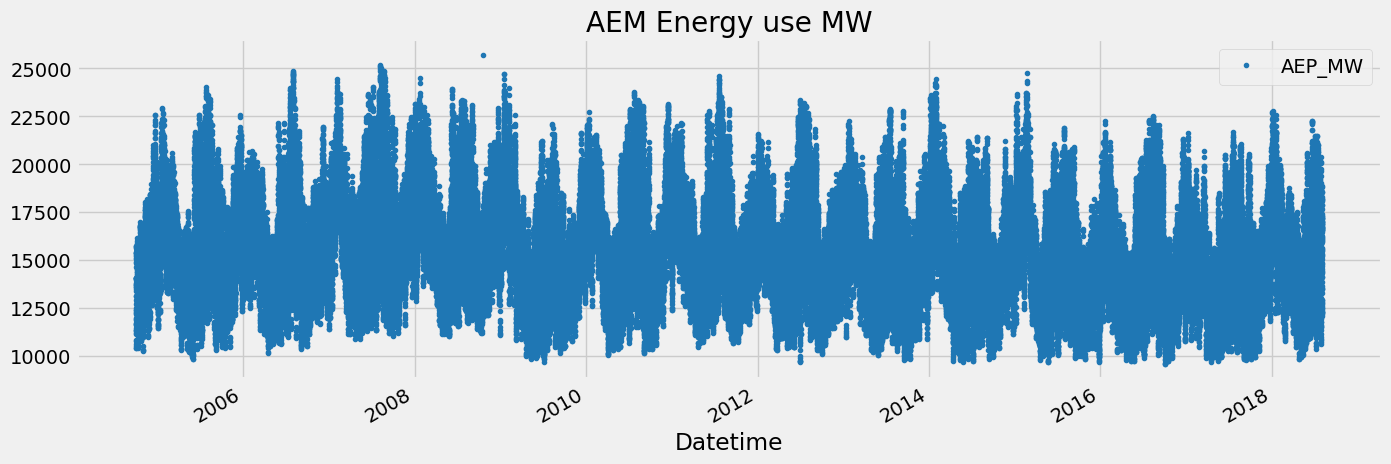

In [6]:
df.plot(style='.', figsize=(15, 5), color=color_pal[0], title='AEM Energy use MW')
plt.show()

In [7]:
df.index

DatetimeIndex(['2004-12-31 01:00:00', '2004-12-31 02:00:00',
               '2004-12-31 03:00:00', '2004-12-31 04:00:00',
               '2004-12-31 05:00:00', '2004-12-31 06:00:00',
               '2004-12-31 07:00:00', '2004-12-31 08:00:00',
               '2004-12-31 09:00:00', '2004-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=121273, freq=None)

## Train/Test Split

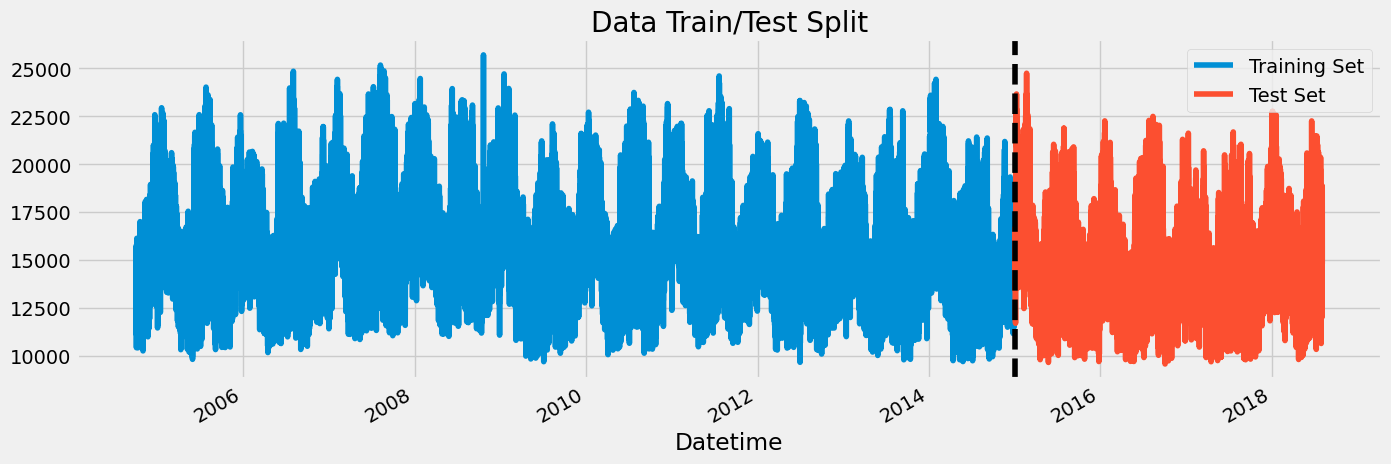

In [8]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

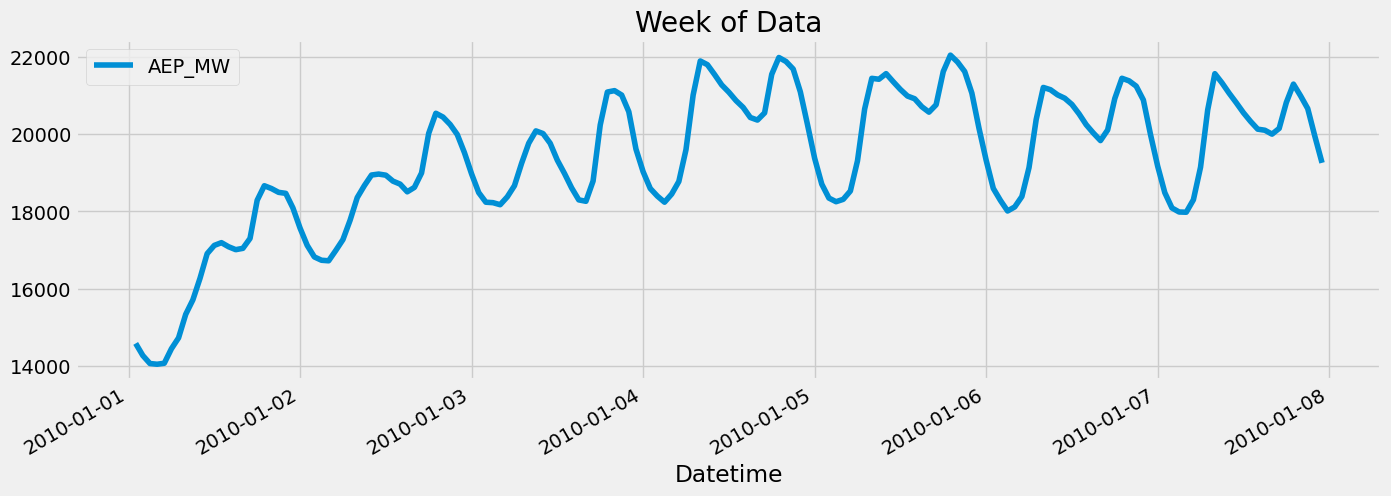

In [9]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15,5), title='Week of Data')
plt.show()

## Create Features

In [10]:
def create_features(df):
    """
    Create time series features basd on time series index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [11]:
df = create_features(df)

In [12]:
df.head()

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2004-12-31 01:00:00,13478.0,1,4,4,12,2004,366
2004-12-31 02:00:00,12865.0,2,4,4,12,2004,366
2004-12-31 03:00:00,12577.0,3,4,4,12,2004,366
2004-12-31 04:00:00,12517.0,4,4,4,12,2004,366
2004-12-31 05:00:00,12670.0,5,4,4,12,2004,366


## Visualize our Feature / Target Relationship

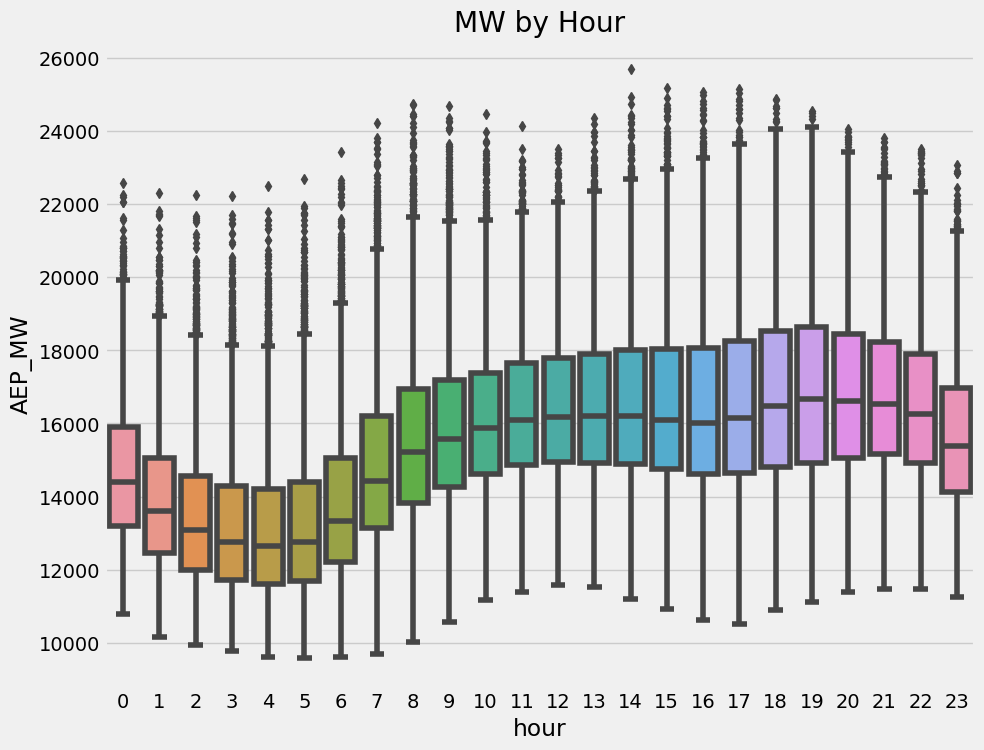

In [13]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='AEP_MW')
ax.set_title('MW by Hour')
plt.show()

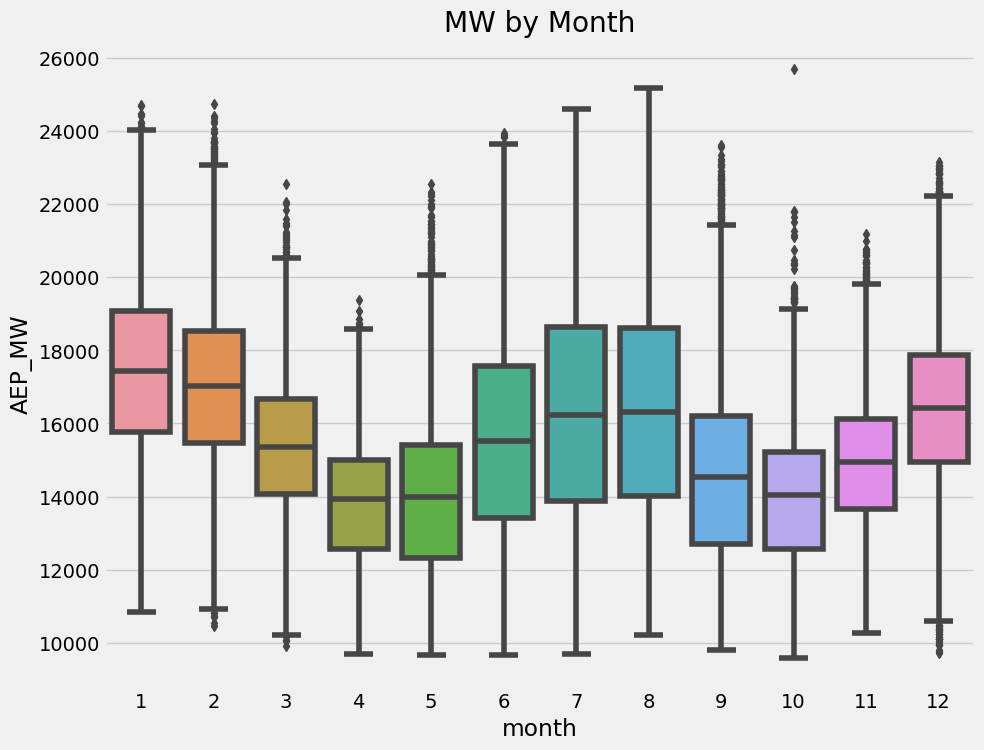

In [14]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y='AEP_MW')
ax.set_title('MW by Month')
plt.show()

## Create our Model

In [15]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'AEP_MW'

In [16]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [17]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                       learning_rate=0.01)

reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:15792.50936	validation_1-rmse:14861.30366
[100]	validation_0-rmse:5946.76890	validation_1-rmse:5177.35119
[200]	validation_0-rmse:2508.95368	validation_1-rmse:2124.36626
[300]	validation_0-rmse:1472.70614	validation_1-rmse:1577.19471
[382]	validation_0-rmse:1226.48428	validation_1-rmse:1578.89350


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Feature Importance

In [18]:
fi = pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=['importance'])

In [19]:
fi

,importance
hour,0.431384
dayofweek,0.188986
quarter,0.018132
month,0.177474
year,0.051083
dayofyear,0.132941


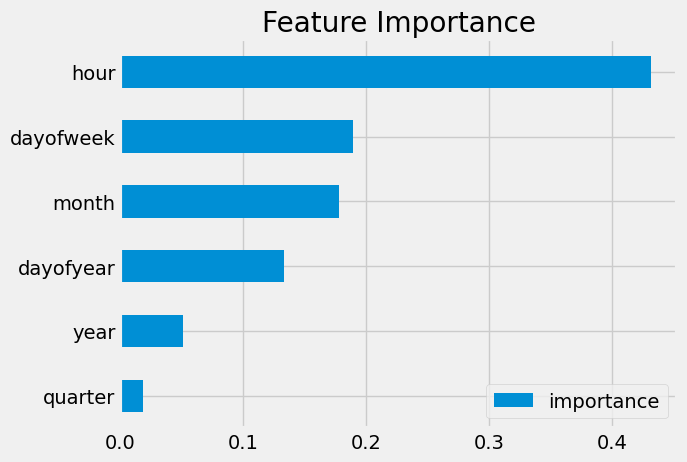

In [20]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forescast on Test

In [21]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

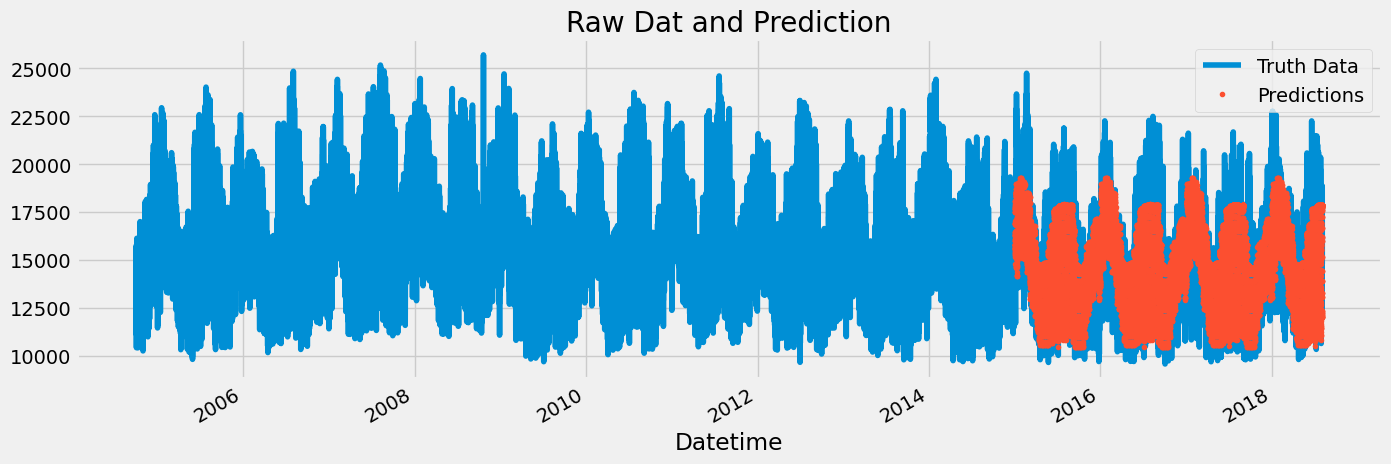

In [22]:
ax = df[['AEP_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

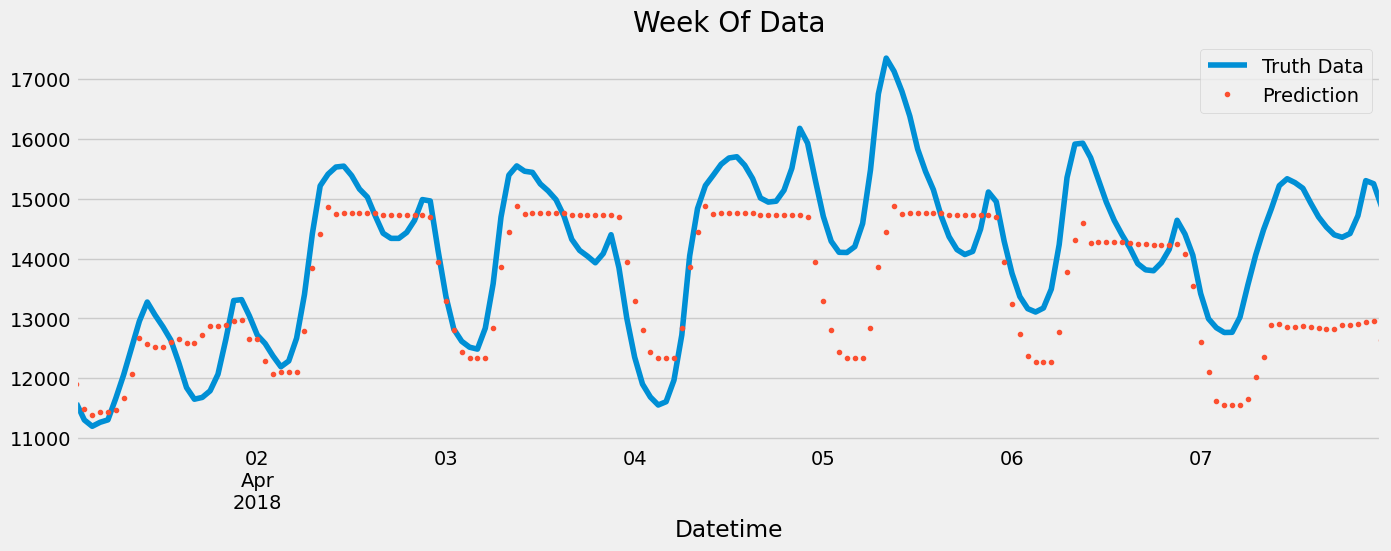

In [24]:
ax  = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['AEP_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

In [26]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1563.38


# Calculate Error

- Look at the worst and best predicted days

In [32]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(5)

date
2015-02-20    5461.675130
2015-02-19    5360.712606
2018-01-06    5083.077718
2018-01-07    4693.319539
2015-02-16    4321.795817
Name: error, dtype: float64

In [54]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(5)

date
2015-09-26    207.230632
2017-05-21    210.977254
2017-11-16    213.768026
2017-10-12    220.800659
2016-06-05    222.770793
Name: error, dtype: float64

# Next Steps

- More robust crosss validation
- Add more features (weather forecast, holidays)